### EDA On Netflix Dataset


In [22]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import plotly.io as pio
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
from collections import Counter

#### Imputing Missing Values, Checking Duplicates and Fixing data types (if needed)

In [2]:
data  = pd.read_csv('netflix_titles.csv')
netflix_overall = pd.DataFrame(data)
print(netflix_overall.head())
print(netflix_overall.columns)

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

In [3]:
# Attributes Director, cast, country, date_added, ratinf and duration have null values in descending order respectively
# print(netflix_overall.isna().sum())
# Missing rates in the dataframe
for i in netflix_overall.columns:
    null_rate = netflix_overall[i].isna().sum() / len(netflix_overall) * 100
    if null_rate > 0:
        print(" {} null_rate ->  {}%".format(i, round(null_rate,2)))   

 director null_rate ->  29.91%
 cast null_rate ->  9.37%
 country null_rate ->  9.44%
 date_added null_rate ->  0.11%
 rating null_rate ->  0.05%
 duration null_rate ->  0.03%


5 columns have missing values, with Director missing almost 1/3 of the time

## Dealing with Missing Values
- Replacing Blank Countries with mode country 

- I have decided not to drop directors and cast, as it could be interesting to look at movies of particular directors and genres

In [4]:
netflix_overall['country'] = netflix_overall['country'].fillna(netflix_overall['country'].mode()[0])
netflix_overall['cast'].replace(np.nan, 'No Data', inplace=True)
netflix_overall['director'].replace(np.nan, 'No Data', inplace=True)

# dropping duplicate values
netflix_overall.drop_duplicates(inplace=True)
#check if the values are imputed
print(netflix_overall.isna().sum())


show_id          0
type             0
title            0
director         0
cast             0
country          0
date_added      10
release_year     0
rating           4
duration         3
listed_in        0
description      0
dtype: int64


In [5]:
print(netflix_overall['date_added'].dtype)
#it outputs, 'object' which means there are different date formats
netflix_overall['date_added'] = pd.to_datetime(netflix_overall['date_added'], errors='coerce')
netflix_overall[netflix_overall['date_added'].isnull()]['date_added']

# Let's have a look at the date_added missing values' other attributes
print(netflix_overall[netflix_overall['date_added'].isnull()].head())
# print(netflix_overall[netflix_overall['date_added'].isnull()].shape)
#there are 98 missing values in the date format, which shows 'NaT' not a time type
# we will replace those values with (release_year + 1) value if it is a movie/series both,
# estimating that those movies 

#Dropped rest of the Nan values
print(netflix_overall.shape)
netflix_overall.dropna(inplace=True)
print(netflix_overall.shape)


object
     show_id     type                                        title  \
6066   s6067  TV Show  A Young Doctor's Notebook and Other Stories   
6079   s6080  TV Show                              Abnormal Summit   
6174   s6175  TV Show              Anthony Bourdain: Parts Unknown   
6177   s6178  TV Show                                     忍者ハットリくん   
6213   s6214  TV Show                                Bad Education   

                     director  \
6066                  No Data   
6079  Jung-ah Im, Seung-uk Jo   
6174                  No Data   
6177                  No Data   
6213                  No Data   

                                                   cast         country  \
6066  Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...  United Kingdom   
6079           Hyun-moo Jun, Si-kyung Sung, Se-yoon Yoo     South Korea   
6174                                   Anthony Bourdain   United States   
6177                                            No Data           Japan  

In [6]:
# Seperating Shows and Movies, performing analysis differently on shows and movies
netflix_shows = netflix_overall[netflix_overall['type'] == 'TV Show']
netflix_movies = netflix_overall[netflix_overall['type'] == 'Movie']

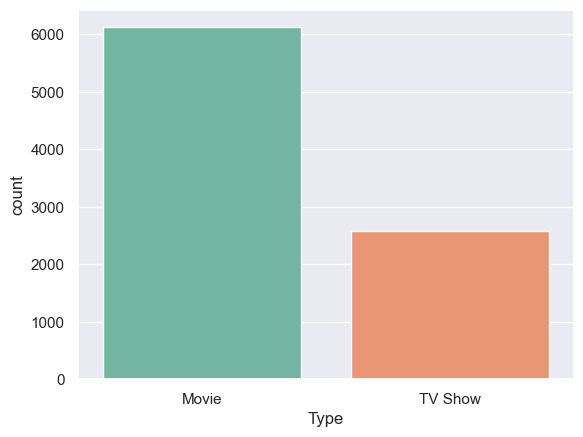

In [7]:
sns.set_theme(style='darkgrid',palette='pastel')
ax = sns.countplot(x='type', data=netflix_overall, palette='Set2')
plt.xlabel('Type')
plt.show()
#It is evident that there are more movies than shows in this dataset

  date_added  year  month month_name
1 2021-09-24  2021      9  September
2 2021-09-24  2021      9  September
3 2021-09-24  2021      9  September
4 2021-09-24  2021      9  September
5 2021-09-24  2021      9  September
['December', 'November', 'October', 'September', 'August', 'July', 'June', 'May', 'April', 'March', 'February', 'January']


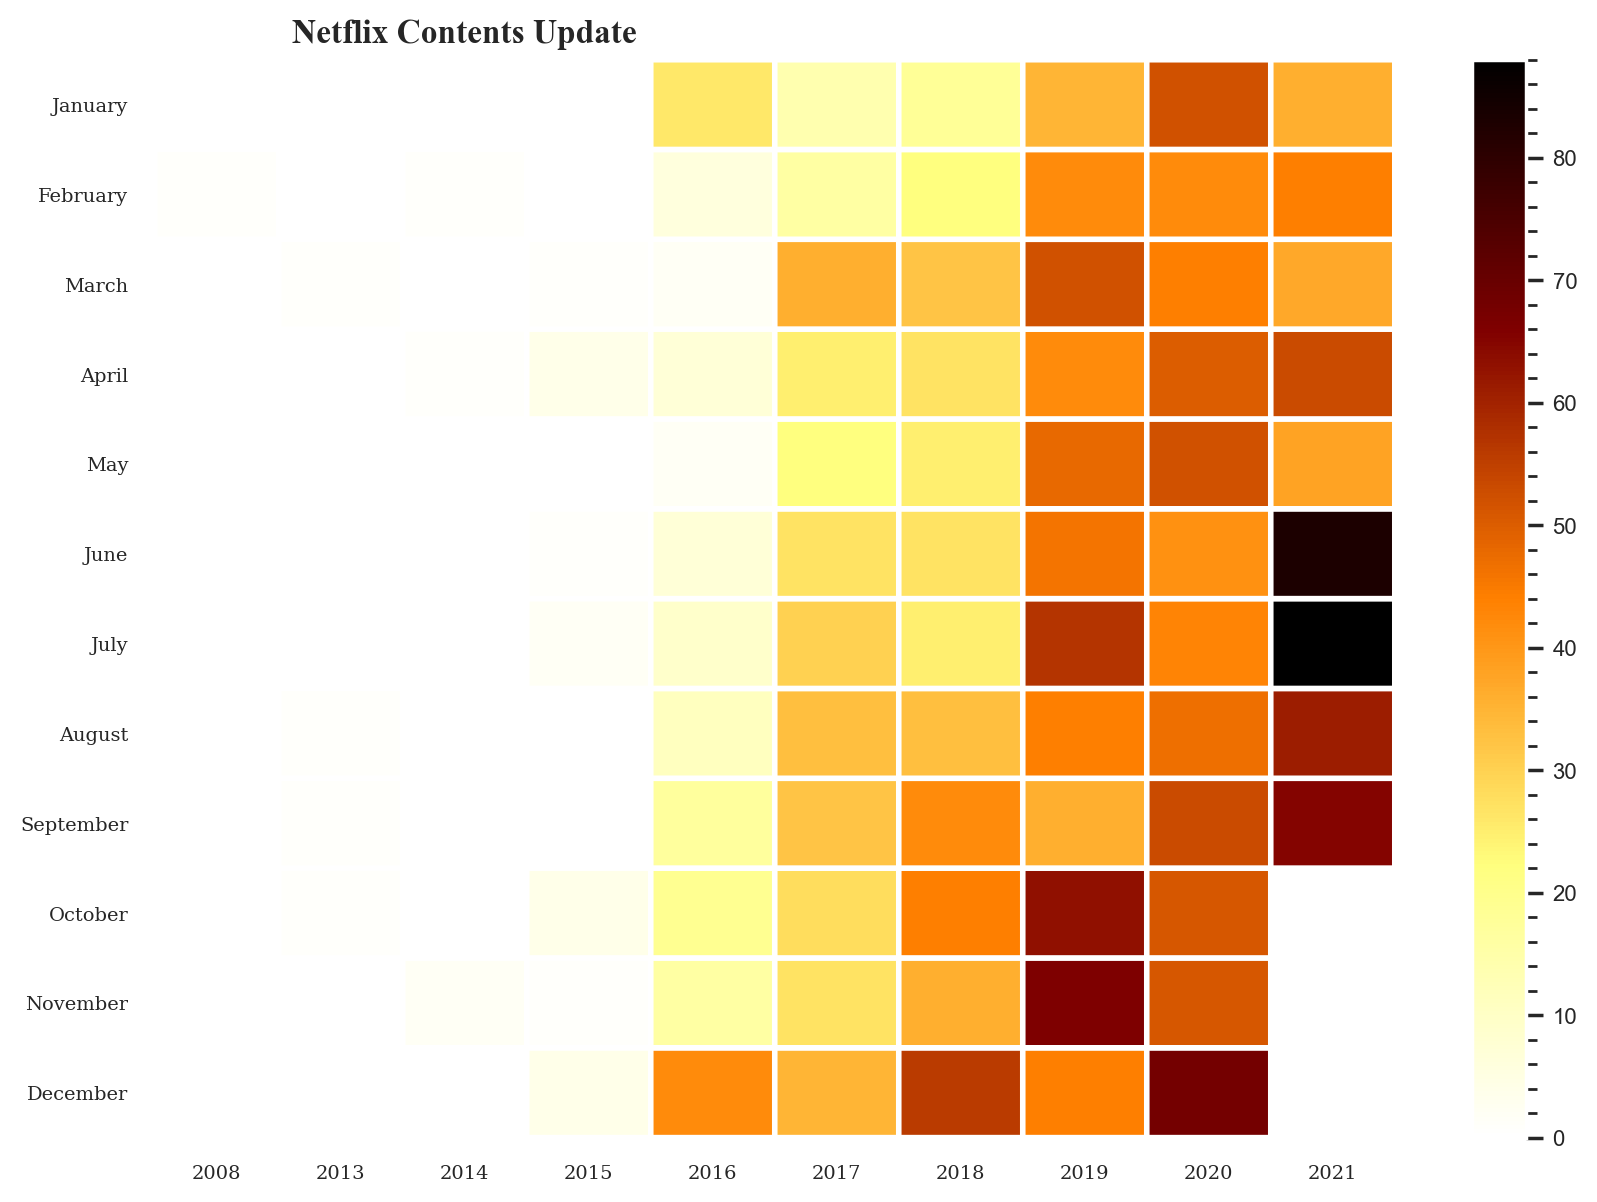

In [8]:
netflix_date = netflix_shows[['date_added']].dropna()
netflix_date['year'] = pd.DatetimeIndex(netflix_date['date_added']).year
netflix_date['month'] = pd.DatetimeIndex(netflix_date['date_added']).month
netflix_date['month_name'] = netflix_date['month'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
})
print(netflix_date.head())

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'][::-1]
print(month_order)


df = netflix_date.groupby('year')['month_name'].value_counts().unstack(level=1).fillna(0)[month_order].T
# print(df)

#plotting
plt.figure(figsize=(10, 7), dpi=200)
plt.pcolor(df, cmap='afmhot_r', edgecolors='white', linewidths=2) # heatmap
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=7, fontfamily='serif')

plt.title('Netflix Contents Update', fontsize=12, fontfamily='Times New Roman', fontweight='bold', position=(0.250, 1.0+0.02))
cbar = plt.colorbar() #heatmap

cbar.ax.tick_params(labelsize=8) 
cbar.ax.minorticks_on()
plt.show()

### Movie Ratings analysis

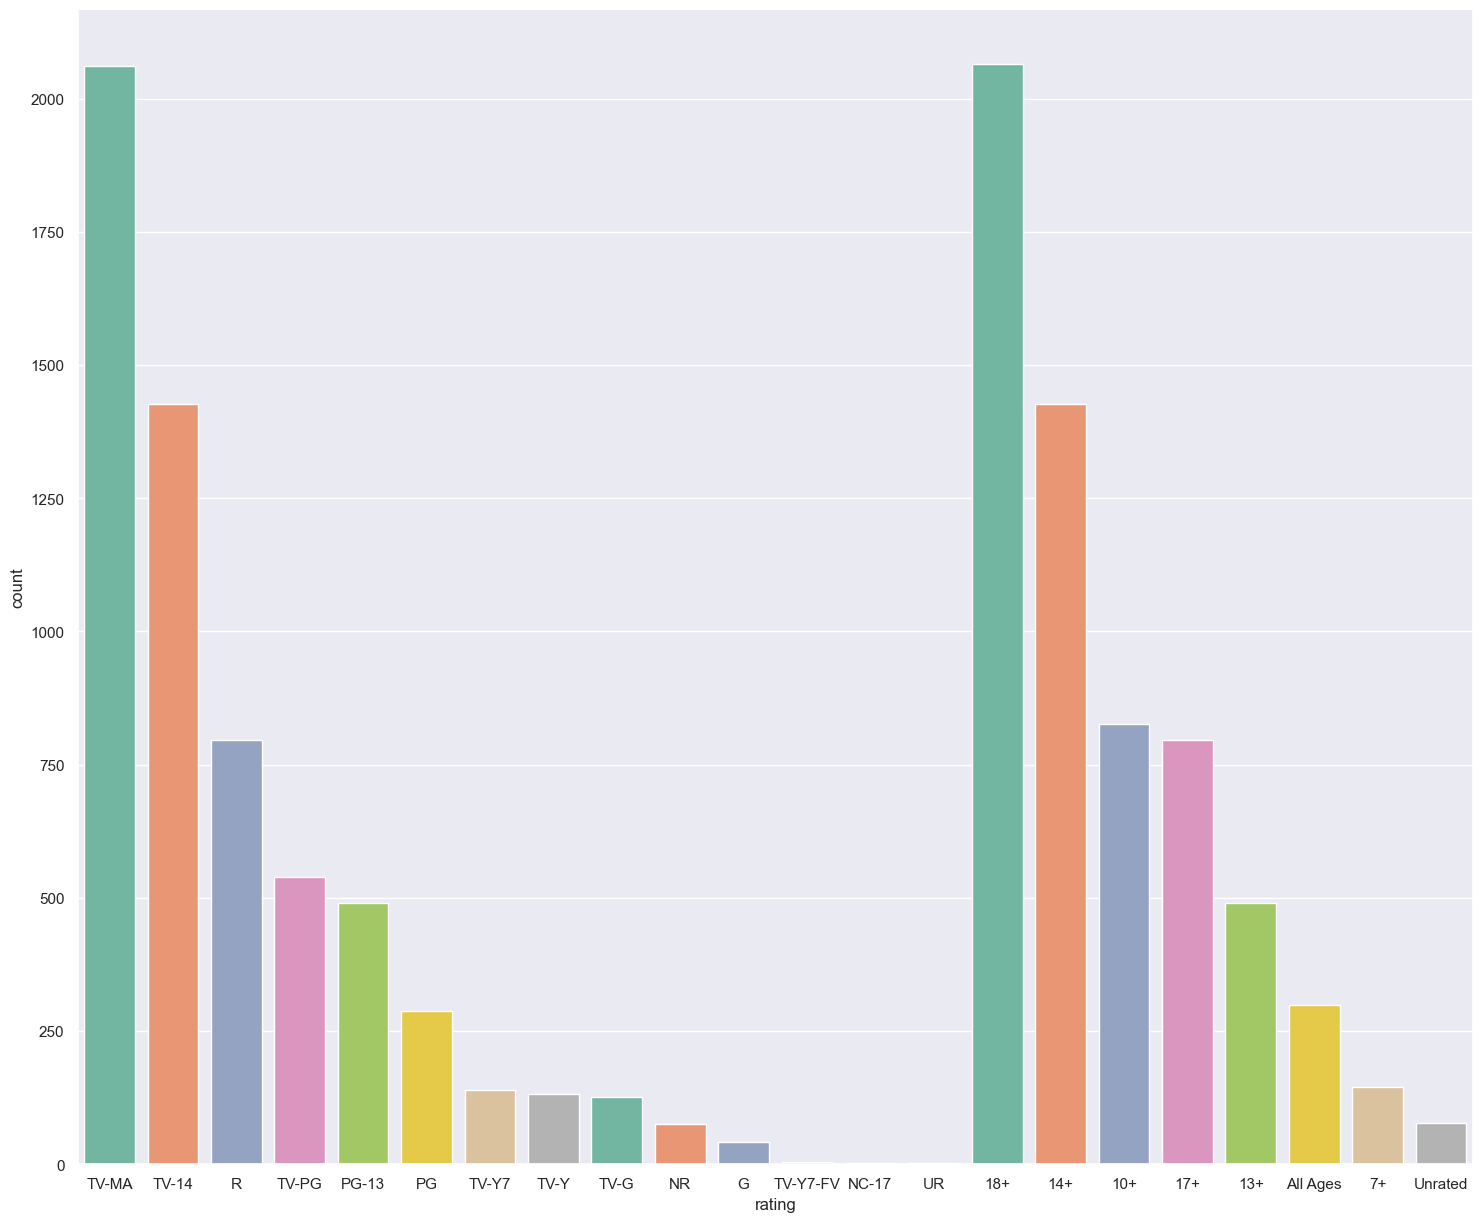

In [9]:
plt.figure(figsize=(18,15))
sns.set_theme(style='darkgrid',palette='pastel')
ax1 = sns.countplot(x='rating', data=netflix_movies, palette='Set2',order=netflix_movies['rating'].value_counts().index[0:15])
# print(netflix_movies['rating'].value_counts().index[0:15])
# We can also map ratings with age groups, for eg. TV-MA for 18+ etc.
rating_age_group = {
    'TV-Y': 'All Ages',
    'TV-G': 'All Ages',
    'TV-Y7': '7+',
    'TV-Y7-FV': '7+',
    'G': 'All Ages',
    'PG': '10+',
    'TV-PG': '10+',
    'PG-13': '13+',
    'TV-14': '14+',
    'R': '17+',
    'TV-MA': '18+',
    'NC-17': '18+',
    'UR': 'Unrated',
    'NR': 'Unrated'
}

netflix_movies['age_group'] = netflix_movies['rating'].map(rating_age_group)
# Created a  new column for age groups,  mapping ratings with rating_age group ages
ax2 = sns.countplot(x='age_group', data=netflix_movies, palette='Set2',order=netflix_movies['age_group'].value_counts().index[0:15])


Most of the moveis are TV-MA rated which is not suitable for children under 18 years of age.

### Top rated movies on Netflix
For that we need IMDB Dataset and perform inner join wrt to netflix movies.


Merging IMDB Datasets with our Netflix Dataset to Analyze top Rated movies/Series and top 10 in various categories!

In [10]:
imdb_merged_data = pd.read_csv('merged_title_ratings_onNetflix.csv')
imdb_merged_data = pd.DataFrame(imdb_merged_data)
print(imdb_merged_data.head())
print(imdb_merged_data.shape)

   Unnamed: 0 show_id     type                             title  \
0           0      s1    Movie              Dick Johnson Is Dead   
1           1      s3  TV Show                         Ganglands   
2           2      s4  TV Show             Jailbirds New Orleans   
3           3      s7    Movie  My Little Pony: A New Generation   
4           4      s8    Movie                           Sankofa   

                        director  \
0                Kirsten Johnson   
1                Julien Leclercq   
2                            NaN   
3  Robert Cullen, José Luis Ucha   
4                   Haile Gerima   

                                                cast  \
0                                                NaN   
1  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...   
2                                                NaN   
3  Vanessa Hudgens, Kimiko Glenn, James Marsden, ...   
4  Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   

                                     

After merging with the IMDB Dataset, we are left with 5556 rows and 26 columns which was (8807, 12) earlier.

In [11]:
imdb_merged_data.columns

Index(['Unnamed: 0', 'show_id', 'type', 'title', 'director', 'cast', 'country',
       'date_added', 'release_year', 'rating', 'duration', 'listed_in',
       'description', 'title_clean', 'tconst', 'titleType', 'primaryTitle',
       'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes',
       'genres', 'primaryTitle_clean', 'averageRating', 'numVotes'],
      dtype='object')

### Top rated movies by IMDB Ratings

In [12]:
# top rated movies on netflix, sorted by average ratings in IMDB
top_rated_movies = imdb_merged_data[imdb_merged_data['type'] == 'Movie'].sort_values(by='averageRating',ascending=False)[0:10]

# print(top_rated_movies)

fig = px.sunburst(top_rated_movies,
                  path = ['title', 'country'],
                  values='averageRating',
                  color_continuous_scale='RdYlGn',
                  color='averageRating',
                  title='Top Rated Netflix Titles by Country',
                  width=1000,    # 📏 Set width in pixels
                  height=800)
fig.show()
pio.write_image(fig, file='TopRatedNetflixTitlesByCountry.png' )
                  

![Stacked Funnel](./TopRatedNetflixTitlesByCountry.png)

Countries with Highest rated content

In [13]:
# Countries with highest rated content.
country_count = imdb_merged_data['country'].value_counts().sort_values(ascending=False)
country_count = pd.DataFrame(country_count)
print("Top Countries")
print(country_count.head(10))
country_count.reset_index(inplace=True)

Top Countries
                count
country              
United States    1716
India             795
United Kingdom    186
South Korea       154
Japan             119
Canada             88
Nigeria            85
Spain              82
France             77
Egypt              75


### Funnel chart showing number of movies in the dataset by country

In [14]:
fig = px.funnel(country_count[0:10], 
                x='count',
                y='country',
               height=1000,
               width=1000,
               )
fig.show()
pio.write_image(fig, file='MoviesByCountry.png' )
                  

### We can also stack multiple Funnel charts in one figure
Taking count of movies and series by country as our new dataframe

In [15]:
# Filtering relevant columns
country_type_count = imdb_merged_data[['country', 'type']].copy()

country_type_count['country'] = country_type_count['country'].fillna("Unknown")

country_type_count = country_type_count.groupby(['country','type']).size().reset_index(name='count')
# country_type_count.sort_values(by='count', ascending=False).head(15)

pivot = country_type_count.pivot(index='country', columns='type', values='count').fillna(0)

pivot_df = pivot.sort_values(by=['Movie','TV Show'], ascending=False)
pivot_df = pivot_df.reset_index()


pivot_df['Total'] = pivot_df['Movie'] + pivot_df['TV Show'] 
pivot_df.head()

top_10  = pivot_df[0:10]
print(top_10)

type                        country   Movie  TV Show   Total
0                     United States  1433.0    283.0  1716.0
1                             India   740.0     55.0   795.0
2                           Unknown   162.0    163.0   325.0
3                    United Kingdom   119.0     67.0   186.0
4                           Nigeria    82.0      3.0    85.0
5                            Canada    75.0     13.0    88.0
6                       Philippines    69.0      1.0    70.0
7                             Spain    67.0     15.0    82.0
8                             Egypt    67.0      8.0    75.0
9     United Kingdom, United States    60.0      2.0    62.0


In [16]:
!pip install -U kaleido
fig = go.Figure()

# Adding movie trace
fig.add_trace(go.Funnel(
    y=top_10['country'],
    x = top_10['Movie'],
    name='Movies',
    marker=dict(color='teal')
))

fig.add_trace(go.Funnel(
    y=top_10['country'],
    x = top_10['TV Show'],
    name='TV Shows',
    marker=dict(color='orange')
))

fig.update_layout(title='Stacked Funnel Chart : Movies & TV Shows by Country',
                  funnelmode = 'stack')

fig.show()
pio.write_html(fig, file='stacked_funnel_movieTV_country.html', auto_open=True)
pio.write_image(fig, file='stacked_funnel_movieTV_country.png' )

#####  We can infer that -> Country with the highest number of movies and TV Shows is USA 
49% of total Movies and 46.4% of Total TV Shows 



****Github Cannot render the plotly interactive charts, So I have embedded PNG directly into the markdown of Jupyter***

![Stacked Funnel](./stacked_funnel_movieTV_country.png)

### Year Wise Analysis

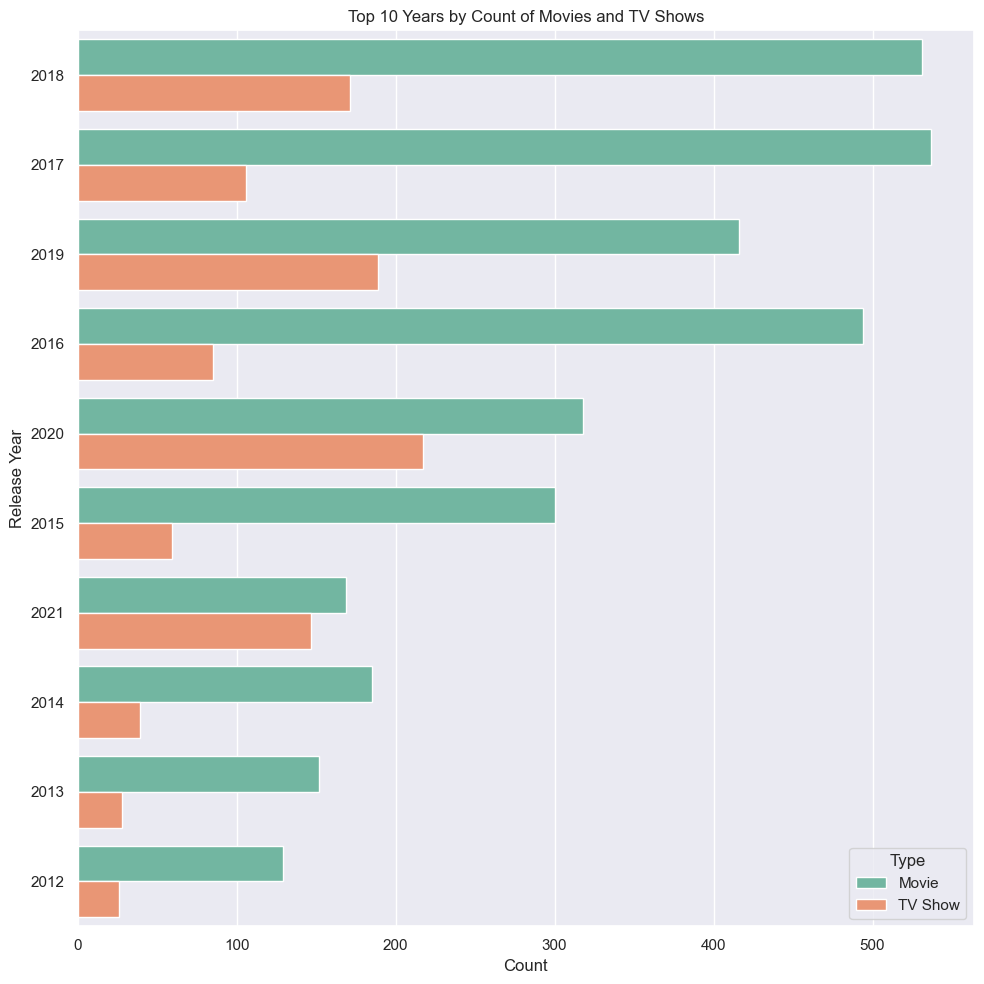

In [17]:
plt.figure(figsize=(10,10))
sns.set(style='darkgrid')

# Top 10  years, most number of movies released by year, counted and not sorted
top_years = imdb_merged_data['release_year'].value_counts().nlargest(10).index
# print(top_years)

#including those years only that are in top_years list
filtered_data = imdb_merged_data[imdb_merged_data['release_year'].isin(top_years)]


sns.countplot(y='release_year',
             data=filtered_data,
             hue='type',
             palette='Set2',
             order=top_years)



plt.title('Top 10 Years by Count of Movies and TV Shows')
plt.xlabel('Count')
plt.ylabel('Release Year')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

### Analysis of duration of Movies

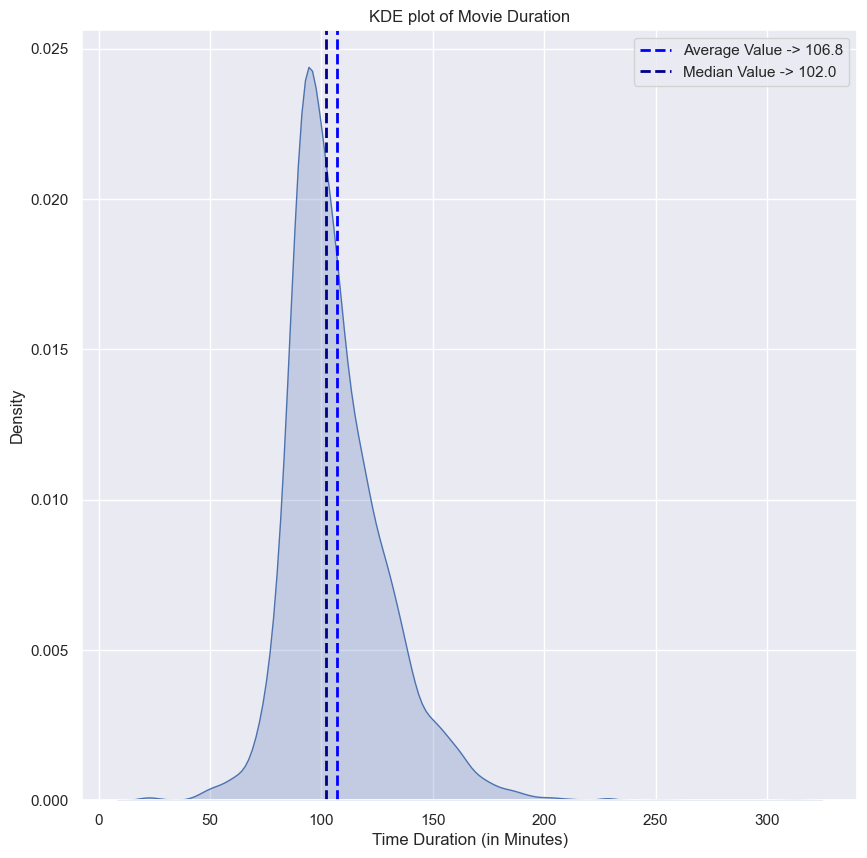

In [18]:
# Removing 'min' from the duration and converting it to number
netflix_movies = imdb_merged_data[imdb_merged_data['type'] == 'Movie'].copy()
netflix_movies['duration_num']=netflix_movies['duration'].str.replace(' min','')
netflix_movies['duration_num']=netflix_movies['duration_num'].astype(str).astype(int)
# netflix_movies['duration_num']
plt.figure(figsize=(10,10))
sns.set_theme(style='darkgrid')
sns.kdeplot(data=netflix_movies['duration_num'],shade=True)



# plotting the average duration line
aver = np.average(netflix_movies['duration_num'])
media = np.median(netflix_movies['duration_num'])
plt.axvline(x=aver, color='blue', linestyle='--', linewidth='2', label=f"Average Value -> {round(aver,1)}")
plt.axvline(x=media, color='darkblue', linestyle='--', linewidth='2', label = f"Median Value -> {media}")
plt.title('KDE plot of Movie Duration')
plt.legend()
plt.xlabel('Time Duration (in Minutes)')
plt.show()

#### This is a right-skewed (also called positively skewed) distribution.
In right-skewed data:
- Mean > Median
- Long tail on the right side
- Most values are concentrated on the left

### Analysis Remaining
- by Genres
- TV Series Analysis
- TV Shows with Largest and Lowest Number of Seasons
-  WordCloud For Genres
- Analyzing the release year of movies and Date the movie was added to netflix
- Creating a recommender System
- Movies and TV Shows Added over time (and cumulative total), Year-by-year and Month-by-month
- Target ages Analysis
- Analysis and comparison of India and USA 
- 